In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정
# %matplotlib notebook
# %matplotlib ipympl
%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
# mpl.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc


#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

original = pd.read_csv('data.csv')

C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6,7,8,10,12,13,14,15,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
original = original.iloc[:,1:]

In [5]:
#스테이션 배정됨 - 16~20번 할당
bright_bf = original[(original["station_nbr"]<40)&(original["station_nbr"]>0)]
# bright_bf

In [6]:
# 스테이션번호로 할당된 스토어 넘버 확인
# set(bright_bf["store_nbr"])

In [7]:
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df

df = type_change_numeric(bright_bf,["station_nbr","codesum","date"])

In [8]:
# 스토어 번호로 할당된 스토어당 아이템 넘버 확인 및 갯수확인
ls = list(set(bright_bf["item_nbr"]))
ls.sort()
store_item = df.pivot_table("units","item_nbr","store_nbr", aggfunc=np.count_nonzero)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
# store_item.astype(int)
cnt = 0
for i in ls:
    print('item_nbr :' ,i)
    print(store_item.loc[i].dropna())
    cnt += len(store_item.loc[i].dropna())
print("총 해야할갯수(최대) : ", cnt)

item_nbr : 1
store_nbr
36    303.0
Name: 1, dtype: float64
item_nbr : 2
store_nbr
3     269.0
26    371.0
28    244.0
Name: 2, dtype: float64
item_nbr : 3
store_nbr
43    258.0
Name: 3, dtype: float64
item_nbr : 4
store_nbr
45    185.0
Name: 4, dtype: float64
item_nbr : 5
store_nbr
2      874.0
3      888.0
7      925.0
8      915.0
9      944.0
10     886.0
13     924.0
15    1009.0
18     939.0
20     894.0
21     912.0
23     937.0
26     946.0
28     884.0
37    1009.0
40    1009.0
42     874.0
44     887.0
Name: 5, dtype: float64
item_nbr : 6
store_nbr
24    957.0
Name: 6, dtype: float64
item_nbr : 7
store_nbr
7    340.0
Name: 7, dtype: float64
item_nbr : 8
store_nbr
29    906.0
Name: 8, dtype: float64
item_nbr : 9
store_nbr
1      919.0
4      959.0
6      874.0
11     898.0
14     819.0
17     938.0
22     895.0
25    1010.0
27     894.0
31     946.0
32    1006.0
33     911.0
34     945.0
36     963.0
38     870.0
39     787.0
45     910.0
Name: 9, dtype: float64
item_nbr : 10
s

In [9]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)

df["date"] = pd.to_datetime(df["date"])
df["tdelta"] = df["tmax"]-df["tmin"]

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['DOW']= df['date'].dt.dayofweek
df['SS']= (df['month']//3)%4 

# df["year"] = df.date.dt.year
# df["month"] = df.date.dt.month
df["quarter"] = df.date.dt.quarter
df["week_day_name"] = df.date.dt.weekday_name
df["day_of_year"] = df.date.dt.dayofyear
df["date"] = pd.to_datetime(df["date"])


In [10]:
# 아이템별 평균계수 삽입
df_m = df.groupby(["store_nbr","item_nbr"]).mean()["units"].reset_index()
df_m.columns = ["store_nbr","item_nbr","units_mean"]
df = df.merge(df_m, left_on=["store_nbr","item_nbr"], right_on=["store_nbr","item_nbr"], how='inner')

In [11]:
#윤년추가
# for idx in range(4,17 + 1):
#     item105.iloc[:,idx].fillna(item105.groupby(["day_of_year","store_nbr"])[item105.columns[idx]].\
#                               transform('mean'), inplace=True)


#depart에 tavg - tavg평균을 넣어주는 함수
def add_depart1(x):
    x.depart.fillna(x.tavg - x.groupby(["day_of_year","store_nbr"])["tavg"].transform('mean'),inplace = True)
    x.depart = x.depart.round(2)
    return x.sort_values(["store_nbr","date","item_nbr"])

add_depart1(df)



#미쿡공휴일 넣기
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = pd.DataFrame()
holidays = cal.holidays("2012","2015")

df["holiday"] = sum([df["date"] == i for i in holidays]) 

#블랙프라이데이 세일기간(11월21~11월30일)
df["BF_SS"] = ((df['month']==11)&(df['day']>=21)&(df['day']<31)).astype(int) 

#블랙프라이데이 당일
blackfriday = pd.to_datetime(['2012-11-23','2013-11-22','2014-11-28'])
df["BF_day"] = sum([df["date"] == i for i in blackfriday]) 


# item105.tmax.fillna(item105.groupby(["day_of_year","store_nbr"])['tmax'].transform('mean'), inplace=True) 

In [12]:
df.iloc[:,22:-13] = df.iloc[:,22:-13].astype(int)
# df.iloc[:,22:-13]

In [13]:
# df['mon'] = (df['DOW']==0).astype(int)
# df['tue'] = (df['DOW']==1).astype(int)
# df['wed'] = (df['DOW']==2).astype(int)
# df['thr'] = (df['DOW']==3).astype(int)
# df['fri'] = (df['DOW']==4).astype(int)
# df['sat'] = (df['DOW']==5).astype(int)
# df['sun'] = (df['DOW']==6).astype(int)
# df['wend'] = (df['DOW']>=5).astype(int)

df['weekend1'] = 0
df.weekend1[df['week_day_name'] == 'Sunday'] = 1
df.weekend1[df['week_day_name'] == 'Saturday'] = 1


df['weekend2'] = 0
df.weekend2[df['week_day_name'] == 'Saturday'] = 1
df.weekend2[df['week_day_name'] == 'Sunday'] = 1
df.weekend2[df['week_day_name'] == 'Friday'] = 1

df['weekend3'] = 0
df.weekend3[df['week_day_name'] == 'Saturday'] = 1
df.weekend3[df['week_day_name'] == 'Monday'] = 1
df.weekend3[df['week_day_name'] == 'Sunday'] = 1


C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\creal\Anaconda3\lib\site-package

In [14]:
# df[df['tue'] == 1]

# 0. 비교플롯 함수화!! 

### 멀티박스플롯함수
- binary한 x변수에 따른 플롯테이블 작성 가능 

In [24]:
# 멀티박스플롯
def HVXY_multi_boxplot(df, Vcol, Xcol, Ycol, cutover=10000, cutlower=-1, Hlist=[], Vlist=[], plotsize=5):
    """This function show boxplot_table============ 

    df : 플롯팅을 할 데이터프레임 이름
    
    H : (Binomial,Carcinality)한 열, Cardinality가 4 이내 추천
    └----Hlist = 리스트형태로 cardinality한 컬럼들을 쓴다.
            예) ["FG","RA","SN","TS","FG+","mon","tue","wed"]
         Hcol = deleted
    
    V : (Cardinality)한 index로 쓸수있는 열
    └---- Vcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Vlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
          
    X : X축은 Cardinality한 값을 넣는다. 
    └---- Xcol = X축으로 사용할 cardinality한 column_name을 쓴다
    
    Y : Y축은 실수형 값을 넣을 수 있다. units등 각종 실수형,정수형 숫자
    └---- Ycol = Y축으로 사용항 실수형,정수형 column_name을 쓴다
    
    cutover : 지정된 값을 초과하는 Y축 데이터는 빼고 플롯팅한다.
    cutlower : 지정된 값보다 작은 Y축 데이터는 빼고 플롯팅한다.
    
    plotsize : 플롯의 사이즈를 지정할 수 있음(정수형)
    
    """

    print("HVXY running...")
    #일단 입력되는 리스트의 크기를 판별한다.
    vsize=len(Vlist)
    hsize=len(Hlist)
    fig = plt.figure(figsize=(plotsize*hsize,plotsize*vsize))
    cnt=0
    for i in range(vsize):
        temp = df[(df[Vcol]==Vlist[i])&(df[Ycol]<cutover)&(df[Ycol]>cutlower)]
        subplot_num = [int(str(vsize)+str(hsize)+str(cnt+k)) for k in range(1,hsize+1)]
        
        print(subplot_num)
        for j in range(hsize):
#             ax = fig.add_subplot(subplot_num[j])
            ax = plt.subplot2grid((vsize+1,hsize+1), (i,j))
            if i == 0:
                sns.boxplot(ax=ax, x=Xcol, y=Ycol, hue=Hlist[j], data=temp).set_title(Hlist[j])
            else : 
                sns.boxplot(ax=ax, x=Xcol, y=Ycol, hue=Hlist[j], data=temp)
            if j == 0 : ax.set_ylabel(str(Vcol)+":"+str(Vlist[i]))
        cnt += hsize
        
    print("plotting screen...", end="")
    plt.show()
    print("Complete!")
    
    return "plot success"


# HVXY_multi_boxplot(df,Vcol="item_nbr",Xcol="store_nbr",Ycol="units",cutover=2500, Hlist=["FG","RA","SN","TS"], Vlist=[15,16,37,44])


### 멀티스캐터플롯 함수
- continuous한 X변수에 따른 플롯테이블 생성

In [16]:
# 멀티reg플롯
def HVXY_multi_regplot(df, Hcol, Vcol, Xcol, Ycol, cutover=10000, cutlower=-1, Hlist=[], Vlist=[], plotsize=5):
    """This function show boxplot_table============ 

    df : 플롯팅을 할 데이터프레임 이름
    
    H : (Cardinality)한 index로 쓸수있는 열
    └---- Hcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Hlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
    
    V : (Cardinality)한 index로 쓸수있는 열
    └---- Vcol = index처럼 쓰일 수 있는 column_name을 쓴다
            예) "item_nbr","store_nbr","station_nbr" 사용가능
          Vlist = 위의 값들 중 특정 값을 찾기위해 쓴다.
          
    X : X축은 Continueous한 값을 넣는다. 
    └---- Xcol = X축으로 사용할 cardinality한 column_name을 쓴다
    
    Y : Y축은 실수형 값을 넣을 수 있다. units등 각종 실수형,정수형 숫자
    └---- Ycol = Y축으로 사용항 실수형,정수형 column_name을 쓴다
    
    cutover : 지정된 값을 초과하는 Y축 데이터는 빼고 플롯팅한다.
    cutlower : 지정된 값보다 작은 Y축 데이터는 빼고 플롯팅한다.
    
    plotsize : 플롯의 사이즈를 지정할 수 있음(정수형)
    
    """

    print("HVXY running...")
    #일단 입력되는 리스트의 크기를 판별한다.
    vsize=len(Vlist)
    hsize=len(Hlist)
    fig = plt.figure(figsize=(plotsize*hsize,plotsize*vsize))
    cnt=0
    for i in range(vsize):
        tmpA = df[(df[Vcol]==Vlist[i])&(df[Ycol]<cutover)&(df[Ycol]>cutlower)]
        subplot_num = [int(str(vsize)+str(hsize)+str(cnt+k)) for k in range(1,hsize+1)]
        print(subplot_num, end="")
        for j in range(hsize):
#             ax = fig.add_subplot(subplot_num[j])
            temp = tmpA[(tmpA[Hcol]==Hlist[j])]
            ax = plt.subplot2grid((vsize+1,hsize+1), (i,j))
            if i == 0:
#                 sns.distplot(ax=ax, x=Xcol, y=Ycol, data=temp, kde=True, rug=True).set_title(str(Hcol)+" : "+str(Hlist[j]))
#                 sns.lmplot(x=Xcol, y=Ycol, data=df, hue='DOW', fit_reg=True)
                try:
                    sns.regplot(ax=ax, x=Xcol, y=Ycol, data=temp).set_title(str(Hcol)+" : "+str(Hlist[j]))
                except:
                    ax.set_title(str(Hcol)+" : "+str(Hlist[j]))
                    print(', can`t plot-',Hlist[j], end="")
            else :
#                 sns.jointplot(ax=ax, x=Xcol, y=Ycol, data=temp)
#                 sns.lmplot(x=Xcol, y=Ycol, data=df, hue='FG', fit_reg=True)
                try:    
                    sns.regplot(ax=ax, x=Xcol, y=Ycol, data=temp)
                except:
                    print(', can`t plot-',Hlist[j], end="")
            if j == 0 : ax.set_ylabel(str(Vcol)+" : "+str(Vlist[i]))
            
        cnt += hsize
        print("")
    print("plotting screen...", end="")
    plt.show()
    print("Complete!")
    
    return "plot success"
# sns.factorplot(x="age", y="sex", hue="survived", row="class", data=data,
#                kind="violin", split=True, size=2, aspect=4)

# HVXY_multi_regplot(df,Hcol="item_nbr",Vcol="store_nbr",Xcol="tmin",Ycol="units",cutover=2500, Hlist=[5,9,93], Vlist=[9,14,17,18,23,31,36,45], plotsize=6)


# lmplot 함수 (자동 테이블화)
- 1축 테이블화 가능한 함수임

In [ ]:
tdf = df[(df["store_nbr"])&(df["item_nbr"]==9)]
sns.lmplot(data=tdf, x="DOW", y="units", col='store_nbr', col_wrap=3, hue="FG+", fit_reg=False, order=1)
plt.show()

In [17]:
# g = sns.PairGrid(df, diag_sharey=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_upper(plt.scatter)
# g.map_diag(sns.kdeplot, lw=3)

# 중간과정 - 특성파악 및 특성치 뽑아내기

In [17]:
# 스토어 번호로 할당된 스토어당 아이템 넘버 확인 및 갯수확인
# 특성형 데이터프레임 뽑아내기
ls = list(set(bright_bf["item_nbr"]))
ls.sort()
store_item = df.pivot_table("units","item_nbr","store_nbr", aggfunc=np.count_nonzero)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
# store_item.astype(int)
cnt = 0
df_char = pd.DataFrame(columns=["item_nbr","store_nbr","sell_days"])
for i in ls:
    print('item_nbr : ' ,i)
    ls2 = store_item.loc[i]
    for j,k in enumerate(ls2):
        if k>0:
            df_char.loc[len(df_char)] = {'item_nbr':i, 'store_nbr':j+1, 'sell_days':k}
            print(" └--store_nbr : ",j+1," / sd : ",k)
    cnt += len(store_item.loc[i].dropna())
    
print("총 해야할갯수(최대) : ", cnt)
df_char

item_nbr :  1
 └--store_nbr :  36  / sd :  303.0
item_nbr :  2
 └--store_nbr :  3  / sd :  269.0
 └--store_nbr :  26  / sd :  371.0
 └--store_nbr :  28  / sd :  244.0
item_nbr :  3
 └--store_nbr :  43  / sd :  258.0
item_nbr :  4
 └--store_nbr :  45  / sd :  185.0
item_nbr :  5
 └--store_nbr :  2  / sd :  874.0
 └--store_nbr :  3  / sd :  888.0
 └--store_nbr :  7  / sd :  925.0
 └--store_nbr :  8  / sd :  915.0
 └--store_nbr :  9  / sd :  944.0
 └--store_nbr :  10  / sd :  886.0
 └--store_nbr :  13  / sd :  924.0
 └--store_nbr :  15  / sd :  1009.0
 └--store_nbr :  18  / sd :  939.0
 └--store_nbr :  20  / sd :  894.0
 └--store_nbr :  21  / sd :  912.0
 └--store_nbr :  23  / sd :  937.0
 └--store_nbr :  26  / sd :  946.0
 └--store_nbr :  28  / sd :  884.0
 └--store_nbr :  37  / sd :  1009.0
 └--store_nbr :  40  / sd :  1009.0
 └--store_nbr :  42  / sd :  874.0
 └--store_nbr :  44  / sd :  887.0
item_nbr :  6
 └--store_nbr :  24  / sd :  957.0
item_nbr :  7
 └--store_nbr :  7  / sd :  34

 └--store_nbr :  3  / sd :  158.0
 └--store_nbr :  4  / sd :  102.0
 └--store_nbr :  5  / sd :  196.0
 └--store_nbr :  7  / sd :  153.0
 └--store_nbr :  8  / sd :  200.0
 └--store_nbr :  9  / sd :  160.0
 └--store_nbr :  10  / sd :  206.0
 └--store_nbr :  12  / sd :  224.0
 └--store_nbr :  13  / sd :  166.0
 └--store_nbr :  14  / sd :  123.0
 └--store_nbr :  15  / sd :  165.0
 └--store_nbr :  16  / sd :  114.0
 └--store_nbr :  19  / sd :  156.0
 └--store_nbr :  20  / sd :  121.0
 └--store_nbr :  22  / sd :  250.0
 └--store_nbr :  25  / sd :  145.0
 └--store_nbr :  27  / sd :  242.0
 └--store_nbr :  31  / sd :  157.0
 └--store_nbr :  32  / sd :  192.0
 └--store_nbr :  33  / sd :  101.0
 └--store_nbr :  34  / sd :  109.0
 └--store_nbr :  35  / sd :  93.0
 └--store_nbr :  38  / sd :  116.0
 └--store_nbr :  40  / sd :  128.0
 └--store_nbr :  41  / sd :  209.0
 └--store_nbr :  43  / sd :  104.0
 └--store_nbr :  44  / sd :  191.0
item_nbr :  94
 └--store_nbr :  44  / sd :  438.0
item_nbr :  

,item_nbr,store_nbr,sell_days
0,1.0,36.0,303.0
1,2.0,3.0,269.0
2,2.0,26.0,371.0
3,2.0,28.0,244.0
4,3.0,43.0,258.0
5,4.0,45.0,185.0
6,5.0,2.0,874.0
7,5.0,3.0,888.0
8,5.0,7.0,925.0
9,5.0,8.0,915.0


In [ ]:
# 한번도 안팔린 달
pivot_df = df.groupby(["item_nbr", "month"]).mean().reset_index().pivot(index =  "month", columns = "item_nbr", values = "units")
pivot_df.style.apply(lambda x: ["background: #F78181" if abs(v) == 0 else "" for v in x], axis = 1)

In [14]:
df["non_zero_units"] = df.units.apply(lambda x : 1 if x > 0 else 0)
df["log_units"] = df.units.apply(lambda x : np.log(x + 1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.log_units, test_size=0.30, random_state=2018)
train = pd.concat([X_train, y_train], axis = 1)

pivot_df = train.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")
pivot_df.style.apply(lambda x: [("background: #F78181" if abs(v) == 0 else "background: #F7C1C1") if abs(v)<1 else "" for v in x], axis = 1)

In [41]:
# 2014.02 이후 안팔림 17, 18, 19, 20, 21, 29, 52

# 2014.04 까지 안팔렸음 22

#2013.10이후 안팔림 24, 33, 69, 86

#2013.08까지 안팔렸음 38 , 47
#2013.08이후 안팔림 42
#2013.09까지 안팔렸음 64
#2013.05이후 안팔림 85, 88
#2013.03이후 안팔림 93
#2013.06이후 안팔림 48, 89
#2013.01이후 안팔림 46
#2013.02이후 안팔림 81
#2012.05까지 안팔렸음 54, 75
#2013.07이후 없음 84


# 기간제 아이템 앞뒤 자르기

# 기간제 아이템 앞뒤 자르기
def cutForeBehindPeriod(df):
    df_ext = df
    print("판매안하던 이전시점 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        for i in range(0,34): #기간월 앞부분 자르기
            if pivot_df.iloc[i,j-1] == 0:
                df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
            else : 
                break
        print(j,".", end="")    
    print("특정일 이후 안파는 데이터 삭제하기 : ")
    for j in range(1,112): #아이템넘버
        for i in range(33,-1,-1): #기간월 뒤부터 자르기
            if pivot_df.iloc[i,j-1] == 0:
                df_ext= df_ext[(df_ext["item_nbr"]!=j)|(df_ext["year"]!=(2012 + i//12))|(df_ext["month"]!=(i%12+1))]
            else : 
                break
        print(j,".", end="") 

    return df_ext

df_a = cutForeBehindPeriod(df)
    
    
df_a[(df_a["item_nbr"]==2)&(df_a["year"]==2012)&(df_a["month"]==1)]

판매안하던 이전시점 삭제하기 : 
1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .특정일 이후 안파는 데이터 삭제하기 : 
1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,units_mean,holiday,BF_SS,BF_day,weekend1,weekend2,weekend3,non_zero_units,log_units,del


In [17]:
pivot_df2 = df_ext.groupby(["item_nbr", "year","month"]).mean().reset_index().pivot_table(index =  ["year","month"], columns = "item_nbr", values = "units")
pivot_df2.style.apply(lambda x: [("background: #F78181" if abs(v) == np.NaN else "background: #F7C1C1") if (abs(v)<1) or (abs(v)==np.NaN)  else "" for v in x], axis = 1)
# df_char.iloc[:,:]
# df_ext[(df_ext["item_nbr"]==2)&(df_ext["year"]==2012)&(df_ext["month"]==1)]

In [ ]:
number = 7
item_n = df[(df["units"]>0)&(df["units"]<2000)&(df["item_nbr"]==number)&(df["store_nbr"]>=0)&(df["store_nbr"]<60)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")

item_n.pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax, x="month", y="units", data=item_n).set_title("월별 판매추이")
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax, x="day", y="units", data=item_n).set_title("일별 판매추이")
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(ax=ax1, x="DOW", y="units", data=item_n).set_title("요일별 판매추이")

plt.show()

# 1. 스토어별 비교 플롯뿌리기

In [ ]:
# 배정된 스토어 = {9, 14, 17, 18, 23, 26, 30, 31, 34, 36, 45}
#       'TS', 'GR', 'RA', 'DZ', 'SN',
#        'SG', 'GS', 'PL', 'FG+', 'FG',
#        'BR', 'UP', 'HZ', 'FU', 'DU',
#        'SQ', 'FZ', 'MI', 'PR', 'BC',
#        'BL', 'VC',
#        'year', 'month', 'day', 'DOW',
#        'SS', 'quarter', 'weekend', 'weekend2',
#        'units_mean'
Hli=["FG","FG+","RA","SN","TS"]
Vli=[9,14,17,18,23]

HVXY_multi_boxplot(df,Vcol="store_nbr",Xcol="item_nbr",Ycol="units",cutover=2500,Vlist=Vli, Hlist=Hli, plotsize=5)


# 2. 아이템별 비교 플롯뿌리기

In [ ]:
# 10개이상의 스토어에서 판매되는 아이템들 = {5,9,45,93}
# 5개 이상의 스토어에서 판매되는 아이템들 = {15,16,37,44,50,68,86,105}
Itemls =[1,2,5,11]

Codels1 =['TS', 'GR', 'RA', 'DZ', 'SN']
Codels2 =['SG', 'GS', 'PL', 'FG+', 'FG']
Codels3 =['BR', 'UP', 'HZ', 'FU', 'DU']
Codels4 =['SQ', 'FZ', 'MI', 'PR', 'BC']
Codels5 =['BL', 'VC', 'weekend1', 'weekend2','weekend3']
Codels6 =['BF_SS', 'BF_day']

df_p = df[df['item_nbr'].apply(lambda x : x in Itemls)]

HVXY_multi_boxplot(df_p, Hlist=Codels1,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels2,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels3,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels4,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels5,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
HVXY_multi_boxplot(df_p, Hlist=Codels6,Vcol="item_nbr",Vlist=Itemls,Xcol="store_nbr",Ycol="units",cutover=2500,cutlower=1, plotsize=5)
# tdf = df[(df["item_nbr"]==5)]
print("units의 요일별 판매추이")
sns.lmplot(data=item_n, x="DOW", y="units", col='store_nbr', col_wrap=3, hue="DOW", fit_reg=True, order=1)

plt.show()

In [56]:
df.corr().round(3)

,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,day,DOW,SS,mon,tue,wed,thr,fri,sat,sun
store_nbr,1.000,-0.156,-0.033,-0.046,-0.061,-0.030,-0.047,0.042,-0.035,-0.041,...,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
item_nbr,-0.156,1.000,-0.206,-0.032,0.021,-0.003,0.009,-0.019,0.009,0.009,...,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
units,-0.033,-0.206,1.000,0.345,0.054,0.051,0.055,0.058,0.025,0.038,...,-0.058,0.037,-0.037,0.007,-0.014,-0.023,-0.028,-0.012,0.023,0.047
station_nbr,-0.046,-0.032,0.345,1.000,0.102,0.134,0.121,-0.042,0.083,0.098,...,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
tmax,-0.061,0.021,0.054,0.102,1.000,0.911,0.979,0.424,0.887,0.946,...,0.030,-0.007,0.507,0.005,0.007,-0.000,0.002,-0.012,-0.002,0.001
tmin,-0.030,-0.003,0.051,0.134,0.911,1.000,0.976,0.383,0.954,0.976,...,0.024,-0.005,0.525,0.009,-0.003,-0.003,-0.001,-0.002,0.005,-0.006
tavg,-0.047,0.009,0.055,0.121,0.979,0.976,1.000,0.410,0.941,0.983,...,0.026,-0.007,0.528,0.007,0.002,-0.001,0.001,-0.008,0.002,-0.003
depart,0.042,-0.019,0.058,-0.042,0.424,0.383,0.410,1.000,0.415,0.421,...,0.022,-0.032,-0.043,0.017,0.017,0.001,0.014,-0.012,-0.024,-0.013
dewpoint,-0.035,0.009,0.025,0.083,0.887,0.954,0.941,0.415,1.000,0.984,...,0.016,0.005,0.534,-0.001,-0.007,-0.001,0.003,-0.001,0.007,-0.001
wetbulb,-0.041,0.009,0.038,0.098,0.946,0.976,0.983,0.421,0.984,1.000,...,0.024,-0.001,0.536,0.001,-0.001,0.001,-0.000,-0.003,0.003,-0.001


In [51]:
import pandas_profiling as pdp
pdp.ProfileReport(df)

Number of variables,58
Number of observations,58938
Total Missing (%),5.4%
Total size in memory,19.6 MiB
Average record size in memory,348.0 B
Numeric,21
Categorical,0
Boolean,28
Date,1
Text (Unique),0
Rejected,8


# VIF다중공산성 판단

In [ ]:
df.columns

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#numeric은 판단이 안되므로 정리한다

dfX = df[['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',\
          'stnpressure', 'sealevel',
          'avgspeed', 'resultspeed', 'resultdir', 'tdelta']]

dfX = dfX.dropna()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

C:\Users\creal\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,tmax
1,inf,tmin
2,1.025791e+05,tavg
3,1.306210e+00,depart
4,7.465311e+01,dewpoint
5,2.571153e+02,wetbulb
6,2.529218e+03,heat
7,7.916133e+02,cool
8,1.754303e+00,stnpressure
9,1.531788e+00,sealevel


In [61]:
df.columns

Index(['date', 'store_nbr', 'item_nbr', 'units', 'station_nbr', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'avgspeed', 'resultspeed', 'resultdir', 'TS', 'GR', 'RA', 'DZ', 'SN',
       'SG', 'GS', 'PL', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'DU', 'SQ', 'FZ',
       'MI', 'PR', 'BC', 'BL', 'VC', 'tdelta', 'year', 'month', 'day', 'DOW',
       'SS', 'quarter', 'week_day_name', 'day_of_year', 'units_mean',
       'holiday', 'BF_SS', 'BF_day', 'weekend1', 'weekend2', 'weekend3'],
      dtype='object')

# 샘플링 및 모델 시험

In [46]:
# 샘플링!
# dfT = df[(df['item_nbr']!=0)&(df['units']<1000)&(df['units']>=0)&(df['store_nbr']!=0)]
dfT = df_ext[(df_ext['item_nbr']!=0)&(df_ext['units']<200)&(df_ext['units']>=0)&(df_ext['store_nbr']!=0)]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfT.iloc[:,1:],\
                                                    dfT.units, test_size=0.30, random_state=2018)

In [47]:
def log_plus_1(x):
    return np.log(x+1) 

formula = "log_plus_1(units) ~ C(item_nbr) + C(store_nbr) + C(month) + C(day) + C(week_day_name) + 0"

model = sm.OLS.from_formula(formula=formula, data=X_train)
# model = sm.Logit.from_formula(formula=formula, data=X_train)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      log_plus_1(units)   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1872.
Date:                Thu, 05 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:41:27   Log-Likelihood:            -2.0032e+05
No. Observations:              148530   AIC:                         4.010e+05
Df Residuals:                  148328   BIC:                         4.030e+05
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(item_nbr)[1]

In [ ]:
#2차 회귀
# formula = "np.log(units+1) ~ C(item_nbr) + C(store_nbr) + C(month) + C(day) + C(weekend1) + C(week_day_name) + 0"

# model = sm.OLS.from_formula(formula=formula, data=X_train)
# # model = sm.Logit.from_formula(formula=formula, data=X_train)
# result = model.fit()

# print(result.summary())

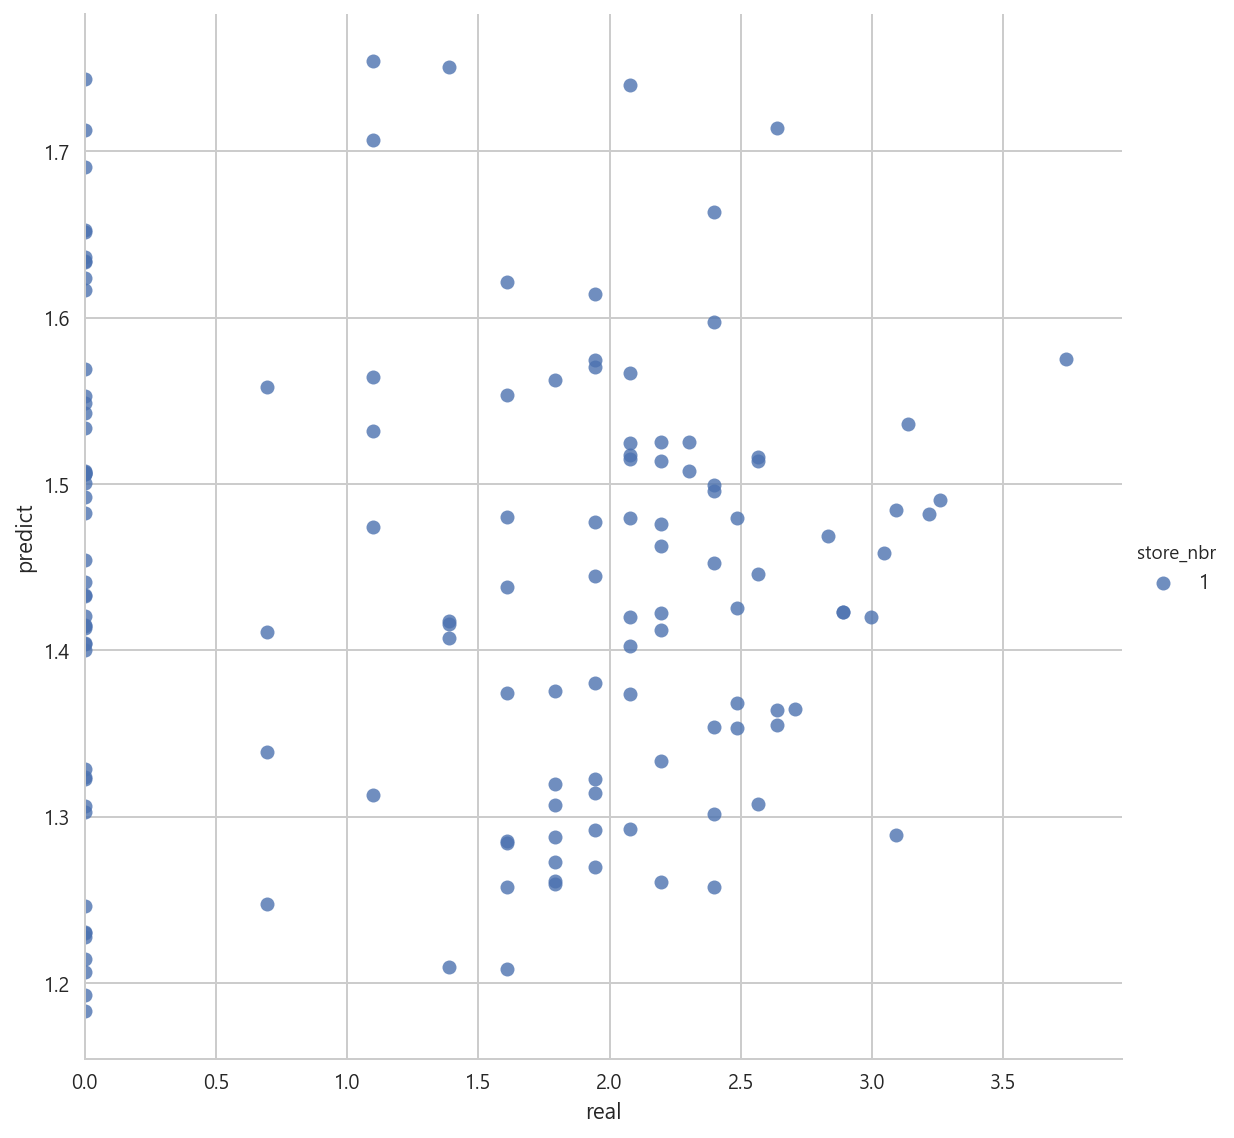

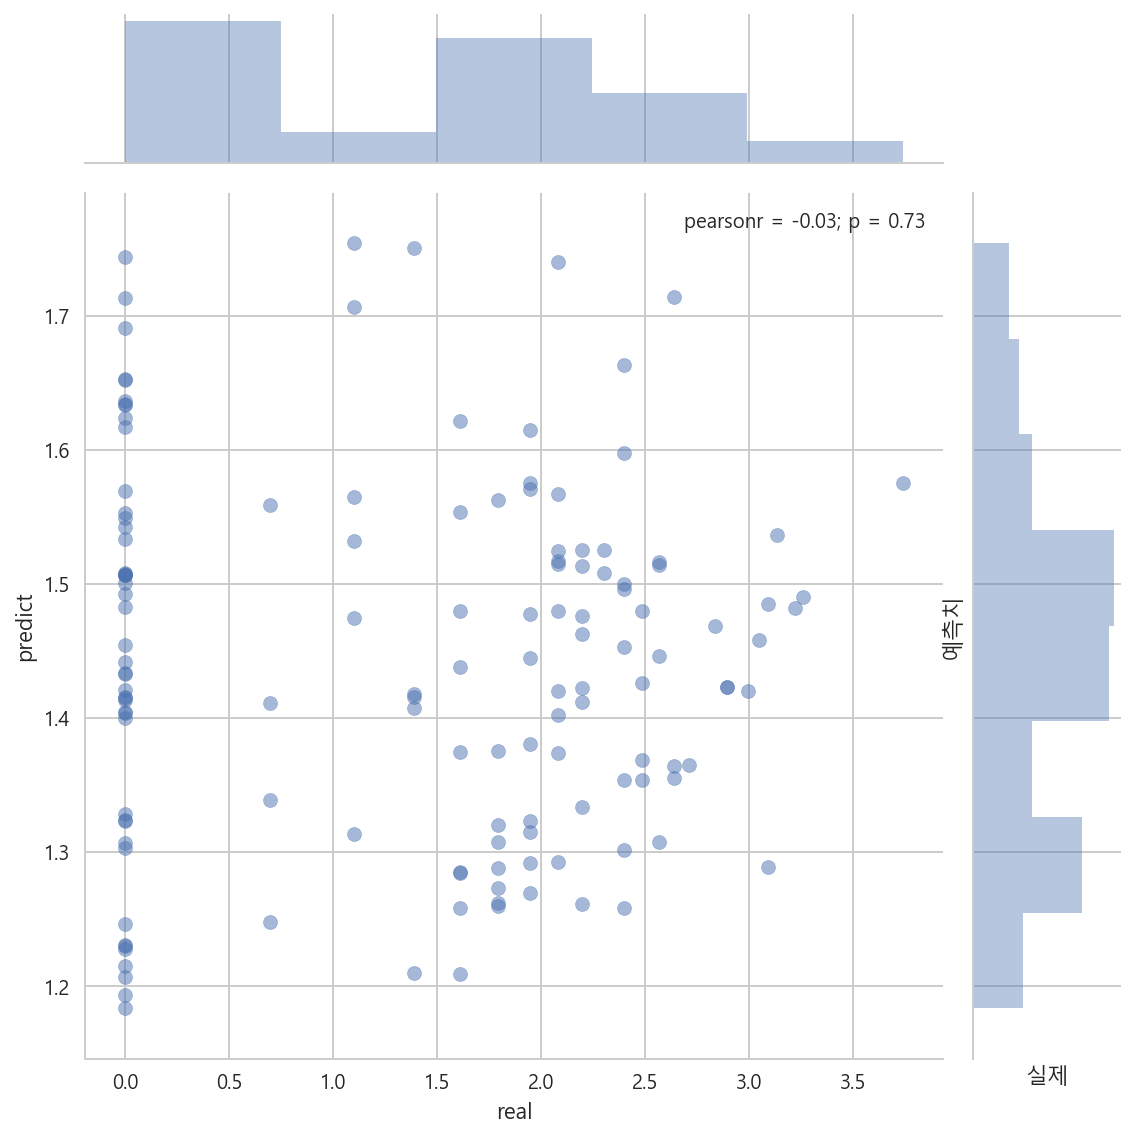

In [44]:
predictions = result.predict(X_test)
da = pd.DataFrame()
da["real"]=np.log(X_test["units"]+1)
da["predict"]=predictions #np.e**predictions
da["item_nbr"]=X_test["item_nbr"]
da["store_nbr"]=X_test["store_nbr"]
da["DOW"]=X_test["DOW"]

findname = "store_nbr"

dat = da[(da['item_nbr']==47)&(da[findname]>=1)&(da[findname]<46)]

g= sns.lmplot(data=dat, x="real", y="predict", hue=findname, size = 8, fit_reg=False)

g.set(xlim=(0, None))

k= sns.jointplot(data=dat, x="real", y="predict", size = 8, alpha=0.5)

# k.set(xlim=(1.4, None))

plt.xlabel(u"실제")
plt.ylabel(u"예측치")
plt.show()



# from sklearn.datasets import make_regression
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# X, y, coef = make_regression(n_samples=1000, n_features=1, noise=20, coef=True, random_state=0)

# model = LinearRegression()
# cv = KFold(10)

# scores = np.zeros(10)
# for i, (train_index, test_index) in enumerate(cv.split(X)):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     scores[i] = r2_score(y_test, y_pred)

# scores

# 아웃라이어, 레버리지

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,8))
# g=sns.lmplot(data=da, x="real", y="predict", size = 8, order=1)
# g.set(xlim=(1.4, None))

idx = hat > 0.05

X_train.units[idx]
Xa=X_train["units"]**0.30
plt.scatter(Xa, predictions)
plt.scatter(Xa[idx], predictions[idx], s=300, c="r", alpha=0.5)

In [ ]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

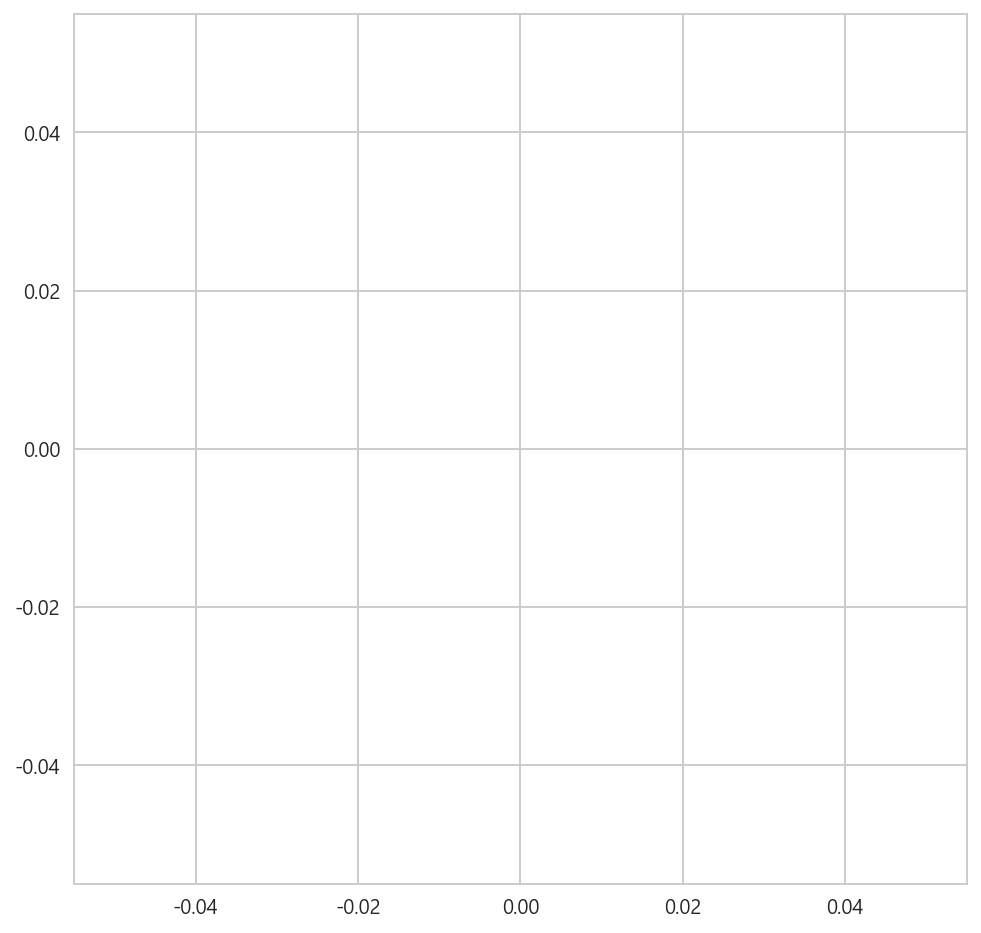

array([   5,   22,   26,   66,   69,   71,   89,   94,  109,  158,  167,
        171,  179,  206,  221,  227,  241,  248,  269,  271,  273,  276,
        278,  296,  303,  319,  342,  363,  375,  401,  420,  423,  427,
        461,  462,  481,  592,  606,  637,  682,  703,  723,  727,  730,
        774,  778,  788,  831,  861,  870,  900,  909,  936,  939,  945,
        951,  955,  990,  991, 1001, 1017, 1037, 1041, 1054, 1076, 1113,
       1118, 1127, 1131, 1134, 1153, 1301, 1318, 1347, 1348, 1360, 1396,
       1408, 1416, 1454, 1469, 1472, 1480, 1525, 1565, 1607, 1611, 1623,
       1631, 1664, 1689, 1690, 1696, 1707, 1717, 1732, 1778, 1813, 1949,
       2008, 2021, 2038, 2042, 2079, 2098, 2107, 2170, 2175, 2187, 2195,
       2196, 2213, 2225, 2241, 2262, 2293, 2305, 2308, 2326, 2333, 2347,
       2352, 2373, 2412, 2427, 2457, 2462, 2473, 2485, 2541, 2549, 2574,
       2582, 2597, 2603, 2604, 2628, 2632, 2643, 2658, 2736, 2768, 2772,
       2861, 2904, 2946, 2973, 2975, 2979, 2982, 29

In [186]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(predictions) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]
plt.figure(figsize=(8,8))
ax = plt.subplot()
# plt.scatter(Xa, predictions)
plt.scatter(Xa[idx], predictions[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(Xa[idx], predictions[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
idx

# 리지, 라쏘 엘라스틱

In [192]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()

In [193]:
result2 = model.fit_regularized(alpha=0.01, L1_wt=0.5)
print(result2.params)
plot_statsmodels(result2) 

C(store_nbr)[5]                  3.352175
C(store_nbr)[12]                 3.944461
C(store_nbr)[16]                 3.768336
C(store_nbr)[19]                 2.677796
C(store_nbr)[30]                 3.989134
C(store_nbr)[41]                 4.031800
C(store_nbr)[43]                 4.358327
C(month)[T.2]                    0.685138
C(month)[T.3]                    0.368112
C(month)[T.4]                    0.000000
C(month)[T.5]                    0.000000
C(month)[T.6]                    0.279492
C(month)[T.7]                    0.336238
C(month)[T.8]                    0.651754
C(month)[T.9]                    0.476960
C(month)[T.10]                   0.331071
C(month)[T.11]                   0.000000
C(month)[T.12]                   0.526373
C(day)[T.2]                      0.705407
C(day)[T.3]                      0.651719
C(day)[T.4]                      0.593237
C(day)[T.5]                      0.910044
C(day)[T.6]                      0.713243
C(day)[T.7]                      0

NameError: name 'X' is not defined

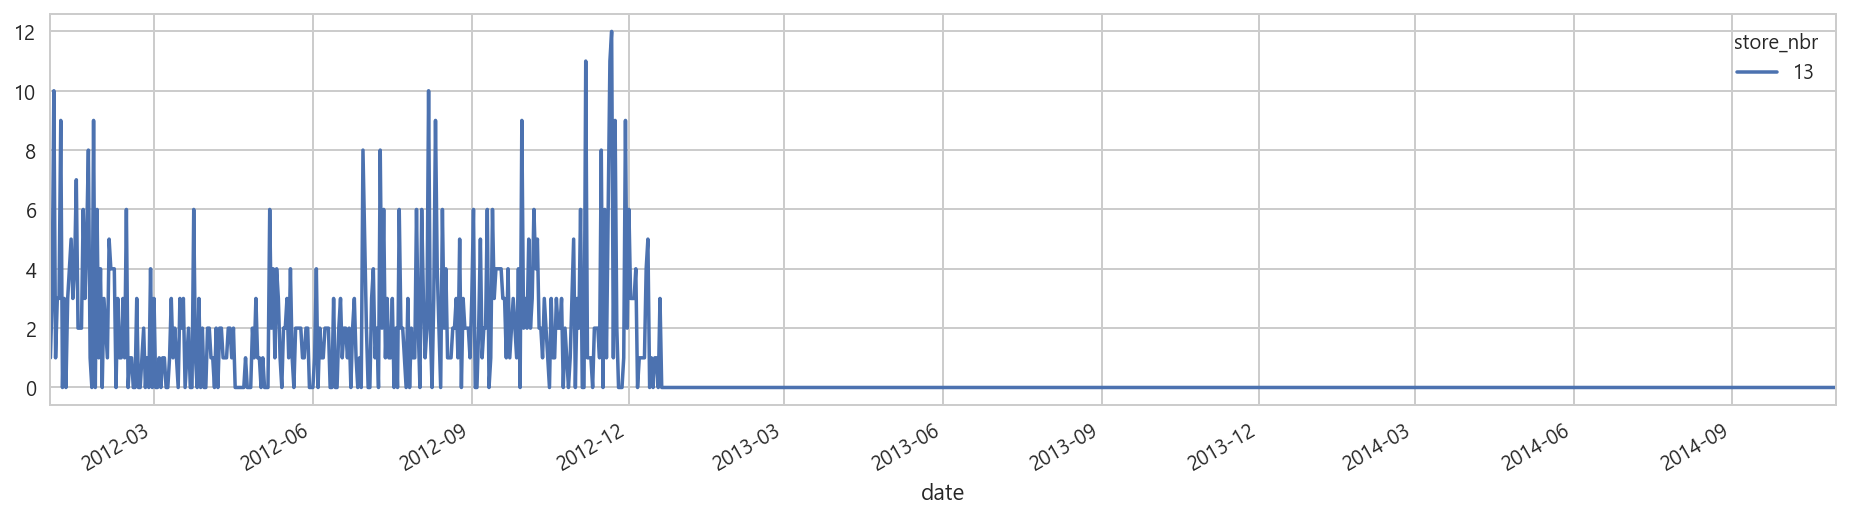

In [237]:
df[df.item_nbr == 46].pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))


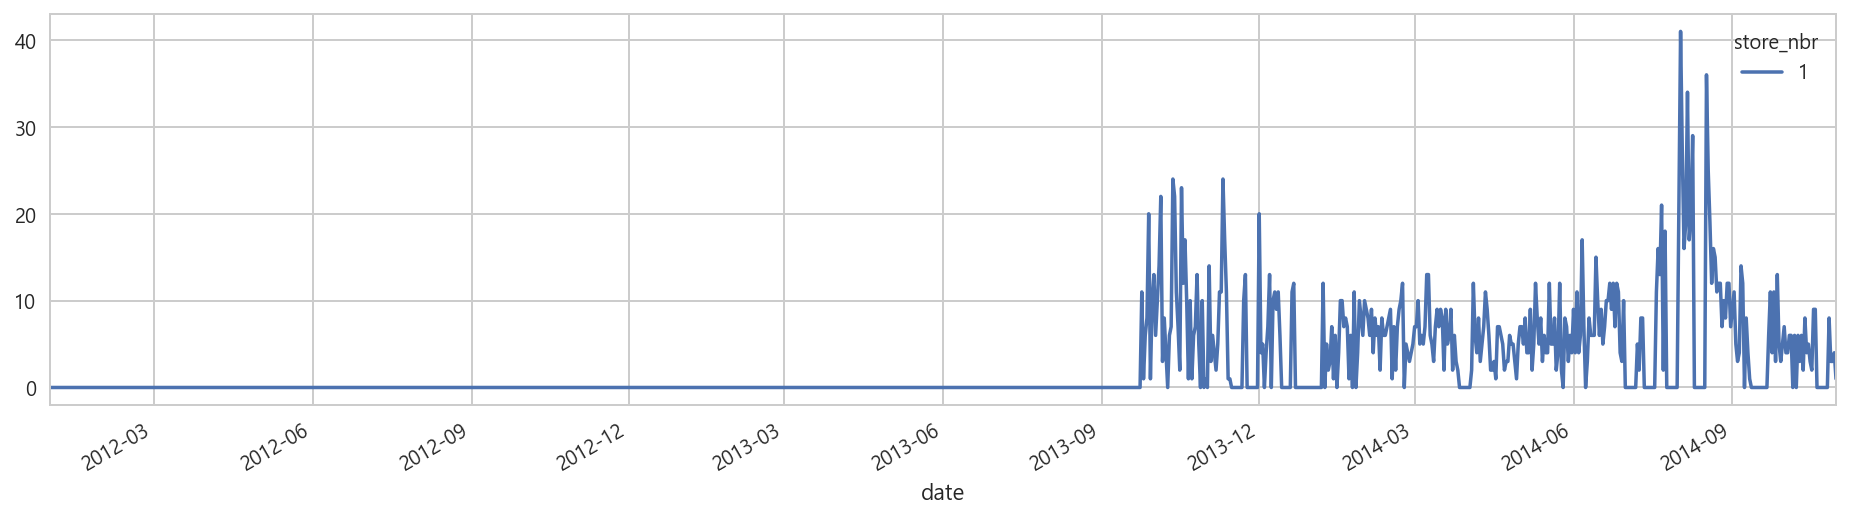

In [238]:
df[df.item_nbr == 47].pivot(index = "date", columns = "store_nbr", values = "units").plot(figsize=(16,4))

In [ ]:
pivot_df = df.groupby(["item_nbr", "month"]).mean().reset_index().pivot(index =  "month", columns = "item_nbr", values = "units")

pivot_df.style.apply(lambda x: ["background: #E7C1C1" if abs(v) < 1 else "" for v in x], axis = 1)
# pivot_df.style.apply(lambda x: ["background: #F7B1B1" for v in x if abs(v) < 1], axis = 1)
# pivot_df.style.apply(lambda x: ["background: #F78181" for v in x if abs(v) == 0], axis = 1)

In [ ]:
pivot_df1 = df.groupby(["item_nbr","store_nbr", "month"]).mean().reset_index().pivot_table(index =  "month", columns = ["item_nbr","store_nbr"], values = "units")
pivot_df1